In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras import backend as K
import os,sys

In [2]:
new_df = pd.read_csv("../data/new_df2.csv")
new_df.drop(columns = 'Unnamed: 0', inplace=True)
new_df.head()


,year,month,day,hour,date,pi_24,wd,ws,wsf,bp,...,ws48,wsf48,bp48,t248,t1048,tt48,rh48,ah48,pi48,pi_cat
0,2000,1,3,2,2000-01-03,0.0,1.281024,-0.146936,0.645370,0.282925,...,1.868523,0.606922,-2.440339,0.608098,0.374977,0.207046,-1.098161,-1.047166,-0.120294,0
1,2000,1,3,3,2000-01-03,0.0,1.295809,-0.153200,0.643234,0.322450,...,1.845136,0.606922,-2.214701,0.282678,0.151059,0.062762,-1.058842,-1.040104,-0.120294,0
2,2000,1,3,4,2000-01-03,0.0,1.310595,-0.159464,0.641098,0.361976,...,1.611266,0.646794,-1.901314,0.022342,-0.049290,-0.042172,-1.006417,-1.016329,-0.120294,0
3,2000,1,3,5,2000-01-03,0.0,1.325380,-0.165729,0.638962,0.401501,...,1.354009,0.606922,-1.564648,-0.135719,-0.155356,-0.068406,-0.993311,-1.019721,-0.120294,0
4,2000,1,3,6,2000-01-03,0.0,1.340165,-0.171993,0.636826,0.441026,...,1.108446,0.567050,-1.287077,-0.237994,-0.226068,-0.081522,-1.006417,-1.044338,-0.120294,0


Where                  
                                       
- `wd` = 'wind direction'
- `ws` = 'wind speed'
- `wsf` = "wind steadiness factor"
- `bp` = "barometric pressure" 
- `t2` = "temp at 2m" (degrees Celsius)
- `t10` = "temp at 10m" (degrees Celsius)
- `tt` = "temp at top of measuring device" (degrees Celsius)
- `rh` = "relative humidity" (percent)
- `ah` = "absolute humidity"
- `pi` = "precipitation intensity"
    - `pi_24` = rolling sum of the previous 24hr precipitation intensity

Time history (lag data): 48 (hrs)

- i.e. `wd6` is wind direction at 6hrs prior to time step of that row 

In [3]:
new_df.columns

Index(['year', 'month', 'day', 'hour', 'date', 'pi_24', 'wd', 'ws', 'wsf',
       'bp',
       ...
       'ws48', 'wsf48', 'bp48', 't248', 't1048', 'tt48', 'rh48', 'ah48',
       'pi48', 'pi_cat'],
      dtype='object', length=497)

In [4]:
new_df[["pi_24","wd","ws","wsf","bp","t2","t10","tt","rh","ah","pi"]].describe()

,pi_24,wd,ws,wsf,bp,t2,t10,tt,rh,ah,pi
count,1.748310e+05,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000,174831.000000
mean,1.050912e+00,-0.000203,-0.000403,-0.000276,0.000090,0.000293,0.000308,0.000234,0.000247,0.000315,0.000049
std,5.290562e+00,1.000060,0.999673,1.000109,1.000049,1.000040,1.000033,1.000095,1.000090,1.000056,1.000200
min,-2.220446e-16,-2.253021,-1.592754,-8.523828,-7.715977,-3.696744,-4.386241,-4.698621,-1.478243,-1.484958,-0.120294
25%,-2.220446e-16,-0.584339,-0.762515,-0.230396,-0.536740,-0.730773,-0.673905,-0.658660,-0.875354,-0.871730,-0.120294
50%,-2.220446e-16,-0.121524,-0.271388,0.367688,0.113313,-0.061338,0.009636,0.049645,-0.259359,-0.227685,-0.120294
75%,4.440892e-16,0.663988,0.547157,0.646794,0.673827,0.710373,0.681392,0.705483,0.789144,0.748664,-0.120294
max,1.260000e+02,2.302948,6.861650,7.385208,3.145103,3.341626,3.545195,3.289484,2.453643,3.133818,41.104188


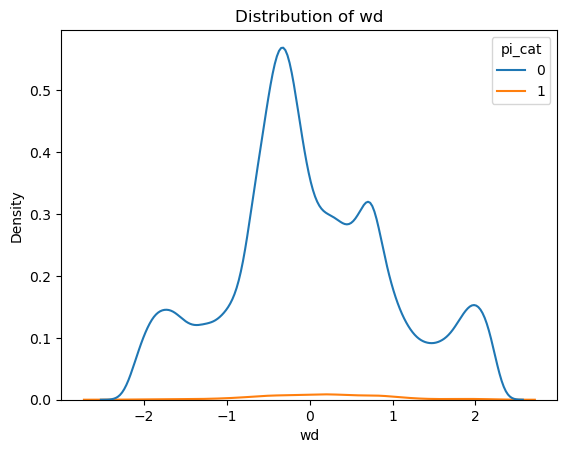

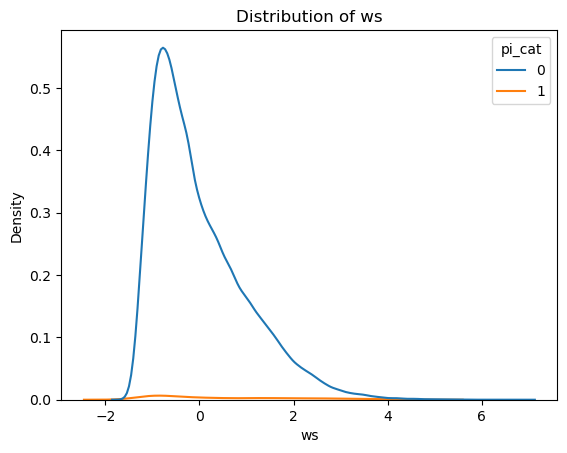

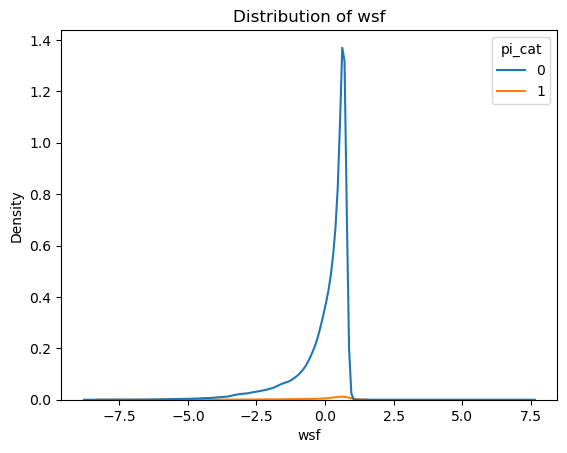

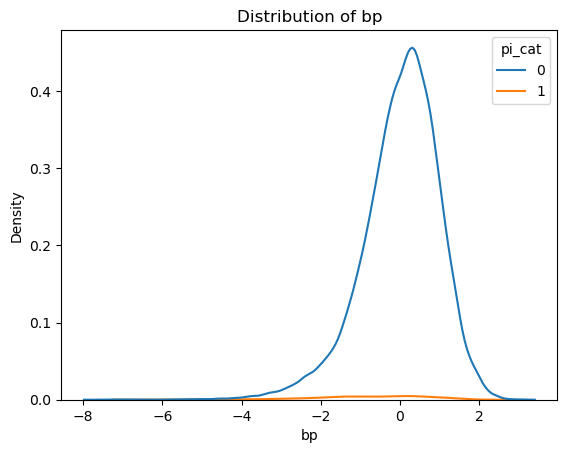

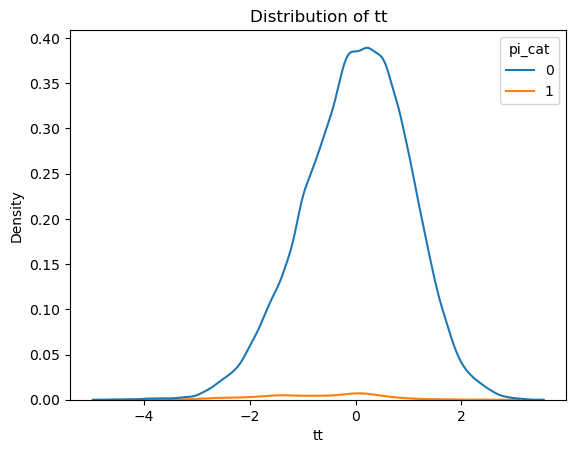

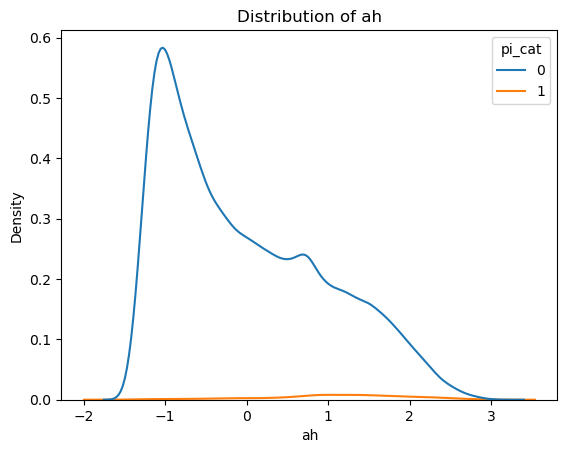

In [5]:
new_df['pi_cat'] = np.where(new_df.pi_24>15,1,0)

for f in ['wd', 'ws', 'wsf', 'bp', 'tt', 'ah']:
    plt.figure()
    sns.kdeplot(data=new_df,x=f, hue ="pi_cat").set(title='Distribution of {}'.format(f))
    plt.show

# Training, testing, features, targets

In [6]:
selective_features = ['wd', 'ws', 'wsf', 'bp', 'tt', 'ah', 'pi', 'wd3', 'ws3', 'wsf3', 'bp3',
                     'tt3', 'ah3', 'pi3', 'wd6', 'ws6', 'wsf6', 'bp6', 'tt6', 'ah6', 'pi6',
                     'wd9', 'ws9', 'wsf9', 'bp9', 'tt9', 'ah9', 'pi9']
cat_target = ['pi_cat']
reg_target = ['pi_24']

## Sequential split

In [7]:
#Ujas' code
split_index = round(new_df.shape[0] * 0.8)

test = new_df[split_index:]
train = new_df[:split_index]

In [8]:
X_train_seq = train[selective_features]
y_train_seq = train[['pi_cat']]
X_test_seq = test[selective_features]
y_test_seq = test[['pi_cat']]


In [9]:
scaler=StandardScaler()
X_train_seq = scaler.fit_transform(X_train_seq)
X_test_seq = scaler.transform(X_test_seq)

## Random split

In [10]:
X = new_df[selective_features]
cat_y = new_df[cat_target]
reg_y = new_df[reg_target]

In [11]:
X_train_rand,X_test_rand,y_train_rand,y_test_rand = train_test_split(X,cat_y,test_size= 0.2,random_state=123)

In [12]:
scaler=StandardScaler()
X_train_rand = scaler.fit_transform(X_train_rand)
X_test_rand = scaler.transform(X_test_rand)

# KNN

In [13]:
KNN = KNeighborsClassifier(n_neighbors=1, metric='cosine', n_jobs=-1)

KNN.fit(X = X_train_rand, y = y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=1)

In [14]:
%%time
preds = KNN.predict(X_test_rand)

CPU times: total: 3min 55s
Wall time: 2min 7s


In [15]:
cm = confusion_matrix(y_test_rand, preds)
cm

array([[34228,   117],
       [  153,   469]], dtype=int64)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

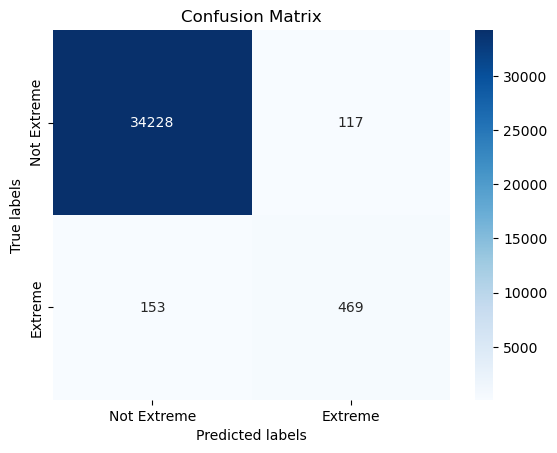

In [16]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

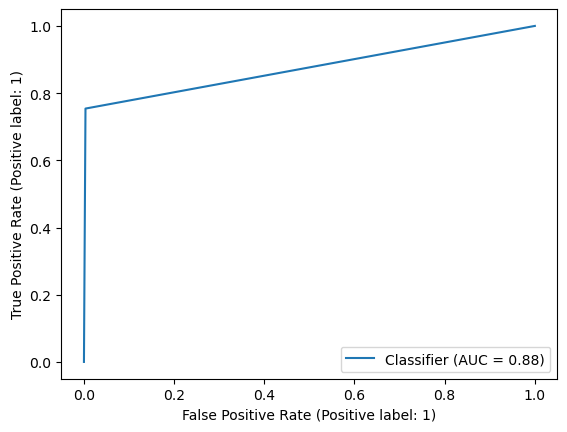

CPU times: total: 3min 54s
Wall time: 2min 4s


In [17]:
%%time
KNN_proba = KNN.predict_proba(X_test_rand)

RocCurveDisplay.from_predictions(y_test_rand, KNN_proba[:,1])
plt.show()

In [18]:
f1_score(y_test_rand, preds)

0.7764900662251657

In [19]:
accuracy_score(y_test_rand, preds)

0.9922784339520119

# Random Forest

In [20]:
%%time
RF = RandomForestClassifier(n_jobs= -1, class_weight=None)

RF.fit(X = X_train_rand, y = y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: total: 3min 4s
Wall time: 26.3 s


RandomForestClassifier(n_jobs=-1)

In [21]:
RF.feature_importances_

array([0.03335224, 0.04253432, 0.02706613, 0.03900688, 0.03543686,
       0.05178192, 0.07988588, 0.03137631, 0.04141702, 0.02725207,
       0.03576981, 0.03210935, 0.04050226, 0.0322969 , 0.03024312,
       0.03954438, 0.02661214, 0.03634941, 0.03058779, 0.03894657,
       0.01738723, 0.0338551 , 0.03709964, 0.02883666, 0.0366421 ,
       0.03344061, 0.04387617, 0.01679112])

In [22]:
%%time
RF_preds = RF.predict(X_test_rand)

CPU times: total: 1.38 s
Wall time: 234 ms


In [23]:
%%time
RF_proba = RF.predict_proba(X_test_rand)

CPU times: total: 1.09 s
Wall time: 230 ms


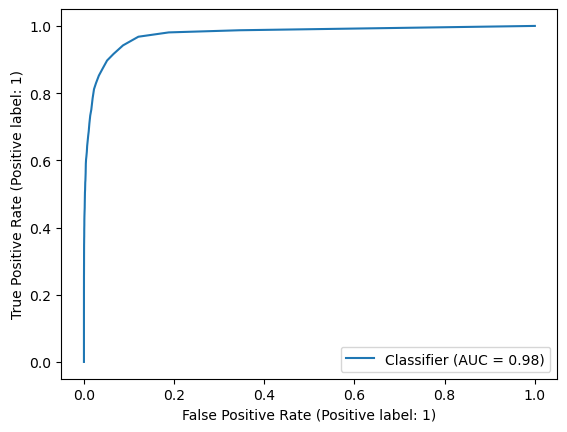

In [24]:
RocCurveDisplay.from_predictions(y_test_rand, RF_proba[:,1])

In [25]:
rf_cm = confusion_matrix(y_test_rand, RF_preds)
rf_cm

array([[34340,     5],
       [  451,   171]], dtype=int64)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

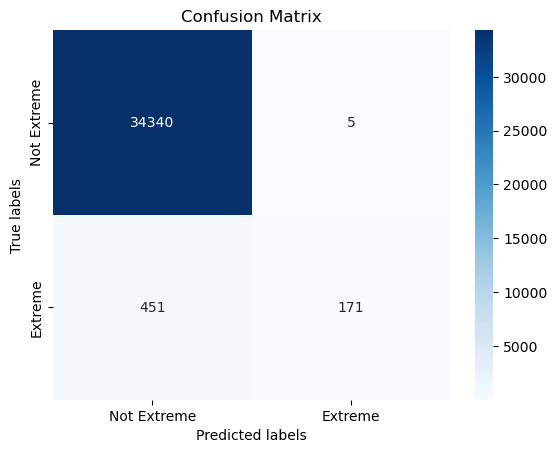

In [26]:
ax= plt.subplot()
sns.heatmap(rf_cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

In [27]:
f1_score(y_test_rand, RF_preds)

0.42857142857142855

In [28]:
accuracy_score(y_test_rand, RF_preds)

0.9869591328967312

# RandomForest Regressor

In [29]:
X_train_rand,X_test_rand,reg_y_train_rand,reg_y_test_rand = train_test_split(X,reg_y,test_size= 0.2,random_state=123)

In [30]:
%%time
RF_reg = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state = 123)

RF_reg.fit(X = X_train_rand, y = reg_y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: total: 37min 32s
Wall time: 5min 52s


RandomForestRegressor(n_jobs=-1, random_state=123)

In [31]:
%%time
RF_reg_preds = RF.predict(X_test_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


CPU times: total: 1.41 s
Wall time: 236 ms


In [32]:
from sklearn.metrics import r2_score
r2_score(reg_y_test_rand, RF_reg_preds)

-0.02398328248624315

In [33]:
RF_reg_preds

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
cat_pred = np.where(RF_reg_preds>15,1,0)

In [35]:
rf_reg_cm = confusion_matrix(y_test_rand,cat_pred)
rf_reg_cm

array([[34345,     0],
       [  622,     0]], dtype=int64)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

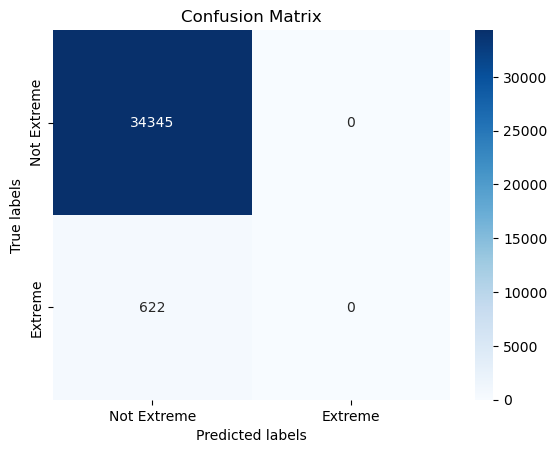

In [36]:
ax= plt.subplot()
sns.heatmap(rf_reg_cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

# LightGBM

In [37]:
parameters = {'boosting_type':['dart'], 
              'learning_rate':[.3,.4,.5, .6],
              'n_jobs': [-1],
              'class_weight': ['balanced']}

lgbmc = LGBMClassifier()

clf = GridSearchCV(lgbmc, 
                   parameters, 
                   scoring= 'f1',
                   n_jobs=-1)

lgbm_fit = clf.fit(X = X_train_rand, y = y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rokka\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2326, number of negative: 137538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6405
[LightGBM] [Info] Number of data points in the train set: 139864, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [38]:
pd.DataFrame(lgbm_fit.cv_results_)[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score').head(10)

,params,mean_test_score,rank_test_score
3,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.449503,1
2,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.417008,2
1,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.384952,3
0,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.345738,4


In [39]:
lgbmc = LGBMClassifier(boosting_type='dart', learning_rate=.4, n_jobs=-1, class_weight='balanced')

lgbmc.fit(X =X_train_rand, y = y_train_rand)

c:\Users\rokka\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rokka\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2326, number of negative: 137538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6405
[LightGBM] [Info] Number of data points in the train set: 139864, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(boosting_type='dart', class_weight='balanced', learning_rate=0.4,
               n_jobs=-1)

In [40]:
LG_preds = lgbmc.predict(X_test_rand)

In [41]:
LG_proba = lgbmc.predict_proba(X_test_rand)

In [42]:
lg_cm = confusion_matrix(y_test_rand, LG_preds)
lg_cm

array([[32921,  1424],
       [  123,   499]], dtype=int64)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

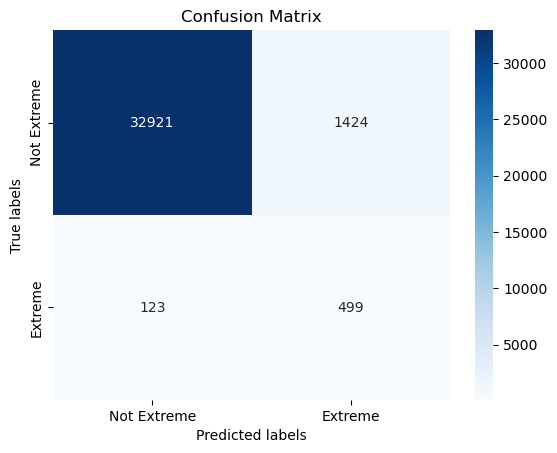

In [43]:
ax= plt.subplot()
sns.heatmap(lg_cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

In [44]:
f1_score(y_test_rand, LG_preds)

0.3921414538310412

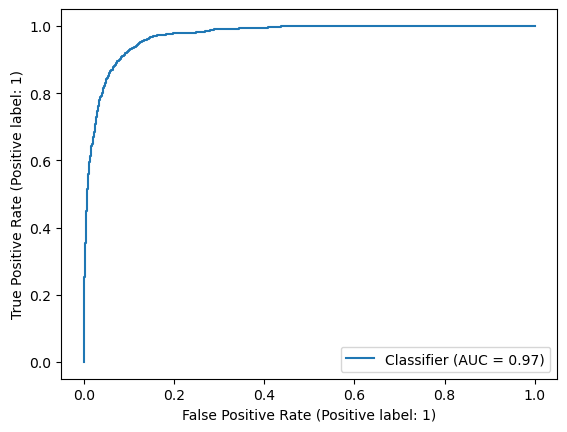

In [45]:
RocCurveDisplay.from_predictions(y_test_rand, LG_proba[:,1])

# GRU

In [54]:
X_train = np.array(X_train_seq).reshape(X_train_seq.shape[0],-1, 7)
X_test = np.array(X_test_seq).reshape(X_test_seq.shape[0],-1, 7)

In [55]:
%%time
class_weights = {0: 1., 1: 70.}
grumod = Sequential()

grumod.add(LSTM(units = 10, return_sequences = True, input_shape = (4, 7)))
grumod.add(Dropout(0.2))

grumod.add(LSTM(units = 3, return_sequences = False))
grumod.add(Dropout(0.2))

grumod.add(Dense(units = 1, activation='sigmoid'))

grumod.compile(optimizer = 'adam', loss = 'binary_crossentropy')

history = grumod.fit(X_train, y_train_seq, validation_data=(X_test,y_test_seq), epochs = 50, batch_size = 512, class_weight = class_weights)

Epoch 1/50
274/274 [==============================] - 11s 16ms/step - loss: 1.1658 - val_loss: 0.5185
Epoch 2/50
274/274 [==============================] - 3s 10ms/step - loss: 0.8818 - val_loss: 0.4661
Epoch 3/50
274/274 [==============================] - 3s 10ms/step - loss: 0.8392 - val_loss: 0.4624
Epoch 4/50
274/274 [==============================] - 3s 10ms/step - loss: 0.8112 - val_loss: 0.5077
Epoch 5/50
274/274 [==============================] - 3s 10ms/step - loss: 0.7895 - val_loss: 0.5010
Epoch 6/50
274/274 [==============================] - 3s 10ms/step - loss: 0.7909 - val_loss: 0.5078
Epoch 7/50
274/274 [==============================] - 3s 10ms/step - loss: 0.7750 - val_loss: 0.4715
Epoch 8/50
274/274 [==============================] - 3s 10ms/step - loss: 0.7568 - val_loss: 0.4740
Epoch 9/50
274/274 [==============================] - 3s 10ms/step - loss: 0.7556 - val_loss: 0.4785
Epoch 10/50
274/274 [==============================] - 3s 10ms/step - loss: 0.7543 - val_l

In [56]:
gru_preds = grumod.predict(X_test[:,:10,:])

1093/1093 [==============================] - 7s 4ms/step


In [57]:
gru_cm = confusion_matrix(y_test_seq,np.round(gru_preds))
gru_cm

array([[27042,  7118],
       [  225,   581]], dtype=int64)

[Text(0, 0.5, 'Not Extreme'), Text(0, 1.5, 'Extreme')]

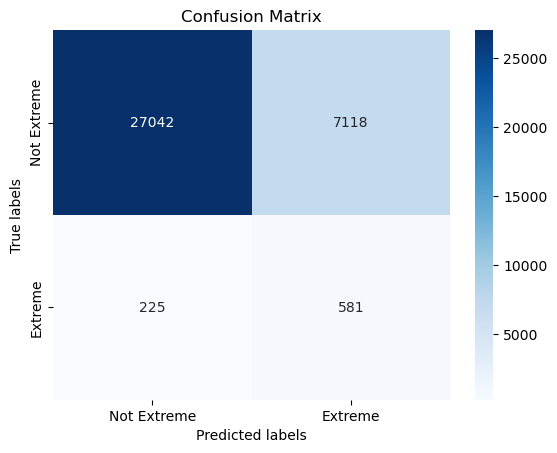

In [58]:
ax= plt.subplot()
sns.heatmap(gru_cm, annot=True, fmt='g', ax=ax, cmap='Blues')  
#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["Not Extreme", "Extreme"])
ax.yaxis.set_ticklabels(["Not Extreme", "Extreme"])

In [60]:
f1_score(y_test_seq,np.round(gru_preds))

0.13662551440329218

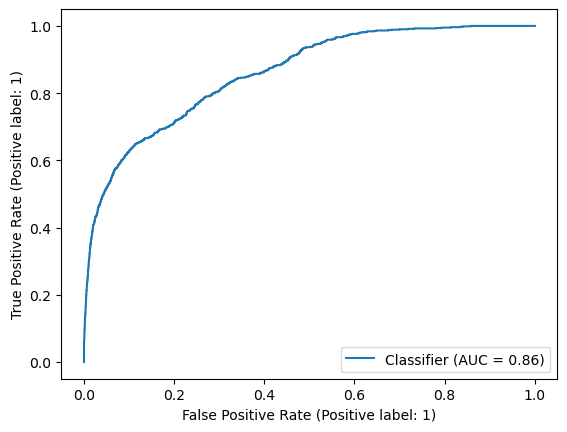

In [61]:
RocCurveDisplay.from_predictions(y_test_seq,gru_preds)